# 兩筆資料集/everyday for the past 8 years：
## i. 道瓊指數開高低收量
## ii.Top 25 頭條

# 以下我們專案處理會分為幾個階段：

# 階段一：資料前處理
　內容包括資料前處理、資料形態處理、NaN補值、correlation map、切分資料子集
# 階段二：模型訓練與調整參數精準度
## 　2.1 機器學習模型比較與參數微調
　　　首先測試八種機器學習模型，後來挑出LDA和XGBoost，並對XGBoost進行重要特徵訓練、參數微調
### 　　　2.1.1 Compare trainging model.
### 　　　2.1.2 Fine Tuning XGBoost
### 　　　2.1.3 Feature Importances:
## 　2.2 PCA transformation:
　　　套用PCA主成分分析，套用到XGBoost與其他的機器學習模型
### 　　　2.2.1 PCA+XGB
### 　　　2.2.2 研究各模型在pca數據調整後的表現情形
### 　　　2.2.3不同主成分下XGboost的表現狀況
# 階段三：實用性測試
　改成預測隔日股市漲跌、拿掉volumn與close、拿掉sentiment analysis來做預測
## 　3.1 隔日股票預測
## 　3.2 實用性預測：短線資料無close,volume
## 　3.3 只預測開高低收
# 結論：這是一篇有誤導性的實作，新聞資料並未起到顯著協助預測的效果。然而以消息面來預測股市還是很重要，但可能必須先處理過新聞，挑出會影響股市的關鍵文本特徵，文本前處理後再投入預測中。

### 首先載入需要的模組


In [167]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
#from pandas import read_csv, set_option
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier

# 階段一：資料前處理
### 在另一專案資料夾「Sentence_Polarity/」已經將sentiment analysis 的五個指標分數作前處理
### 並放在「Sentence_Polarity/combined_stock_data.csv」中
### 另外DJIA的資料集放在「Sentence_Polarity/stocknews/DJIA_table.csv」
### 我們先來查看此兩筆資料集



In [168]:
# Loading the dataset to a dataframe
sentence_file = "Sentence_Polarity/combined_stock_data.csv"
sentence_df = pd.read_csv(sentence_file, parse_dates=[1])
sentence_df.head()

,Unnamed: 0,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,...,Top22,Top23,Top24,Top25,Para,Subjectivity,Objectivity,Positive,Neutral,Negative
0,0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...",...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""","b""Georgia 'downs two Russian warplanes' as cou...",85.714286,14.285714,21.428571,14.285714,64.285714
1,1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",b'Why wont America and Nato help us? If they w...,77.777778,22.222222,33.333333,22.222222,44.444444
2,2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,...,b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",b'Remember that adorable 9-year-old who sang a...,50.000000,50.000000,14.285714,50.000000,35.714286
3,3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",...,b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,b' U.S. refuses Israel weapons to attack Iran:...,40.000000,60.000000,20.000000,60.000000,20.000000
4,4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,...,b'Taliban wages war on humanitarian aid workers',"b'Russia: World ""can forget about"" Georgia\'s...",b'Darfur rebels accuse Sudan of mounting major...,b'Philippines : Peace Advocate say Muslims nee...,b'All the experts admit that we should legalis...,45.454545,54.545455,36.363636,54.545455,9.090909


In [169]:
# Load the stock prices dataset into a dataframe and check the top 5 rows
stock_prices = "Sentence_Polarity/stocknews/DJIA_table.csv"
stock_data = pd.read_csv(stock_prices, parse_dates=[0])
stock_data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


## 我們將兩筆資料做合併處理
### 我們將這五個特徵(Subjectivity, Objectivity, Positive, Negative, Neutral) 與stock_data dataframe結合.

In [170]:
# Create a dataframe by merging the headlines and the stock prices dataframe
merged_dataframe = sentence_df[['Date', 'Label', 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']].merge(stock_data, how='inner', on='Date', left_index=True)
# Check the shape and top 5 rows of the merged dataframe
print(merged_dataframe.shape)
# Push the Label column to the end of the dataframe
cols = list(merged_dataframe)
print(cols)
cols.append(cols.pop(cols.index('Label')))
merged_dataframe = merged_dataframe.loc[:, cols]
merged_dataframe.head()

(1989, 13)
['Date', 'Label', 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']


,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label
1988,2008-08-08,85.714286,14.285714,21.428571,64.285714,14.285714,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0
1987,2008-08-11,77.777778,22.222222,33.333333,44.444444,22.222222,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1
1986,2008-08-12,50.000000,50.000000,14.285714,35.714286,50.000000,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0
1985,2008-08-13,40.000000,60.000000,20.000000,20.000000,60.000000,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,0
1984,2008-08-14,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,1


## 接著我們要將資料型態一致化，以方便後續運算處理（把Volume處理成float型態）


In [171]:
print(merged_dataframe.dtypes)
# Change the datatype of the volume column to float
#merged_dataframe['Date'] = pd.to_datetime(merged_dataframe['Date'])
merged_dataframe['Volume'] = merged_dataframe['Volume'].astype(float)
print(cols)
#merged_dataframe = merged_dataframe.set_index(['Date'])
merged_dataframe.index = merged_dataframe.index.sort_values()
merged_dataframe.head()

Date            datetime64[ns]
Subjectivity           float64
Objectivity            float64
Positive               float64
Negative               float64
Neutral                float64
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Adj Close              float64
Label                    int64
dtype: object
['Date', 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Label']


,Date,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label
0,2008-08-08,85.714286,14.285714,21.428571,64.285714,14.285714,11432.089844,11759.959961,11388.040039,11734.320312,212830000.0,11734.320312,0
1,2008-08-11,77.777778,22.222222,33.333333,44.444444,22.222222,11729.669922,11867.110352,11675.530273,11782.349609,183190000.0,11782.349609,1
2,2008-08-12,50.000000,50.000000,14.285714,35.714286,50.000000,11781.700195,11782.349609,11601.519531,11642.469727,173590000.0,11642.469727,0
3,2008-08-13,40.000000,60.000000,20.000000,20.000000,60.000000,11632.809570,11633.780273,11453.339844,11532.959961,182550000.0,11532.959961,0
4,2008-08-14,45.454545,54.545455,36.363636,9.090909,54.545455,11532.070312,11718.280273,11450.889648,11615.929688,159790000.0,11615.929688,1


## 讓我們確認資料特徵的中位數、平均、標準差等統計敘述


In [172]:
# Check the statistics of the columns of the merged dataframe and check for outliers
print(merged_dataframe.describe())

       Subjectivity  Objectivity     Positive     Negative      Neutral  \
count   1986.000000  1986.000000  1986.000000  1986.000000  1986.000000   
mean      60.907326    39.092674    20.812822    40.094504    39.092674   
std       22.090719    22.090719    18.162142    22.747962    22.090719   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%       43.750000    25.000000     7.142857    25.000000    25.000000   
50%       57.142857    42.857143    18.898810    36.363636    42.857143   
75%       75.000000    56.250000    31.496711    50.000000    56.250000   
max      100.000000   100.000000   100.000000   100.000000   100.000000   

               Open          High           Low         Close        Volume  \
count   1989.000000   1989.000000   1989.000000   1989.000000  1.989000e+03   
mean   13459.116048  13541.303173  13372.931728  13463.032255  1.628110e+08   
std     3143.281634   3136.271725   3150.420934   3144.006996  9.392343e+07   
min     

## 接著我們先來看是否有NaN的資料存在。

### 視覺化NaN 讓我們能夠更清楚的看到NaN資料的分布。以下是我們NaN values的圖表。白線是NaN資料的位置，我們可以看到NaN資料都集中在特定幾天份的情感column，而右側垂直線顯示我們共只有3筆NaN資料

#### In this case, since the NaN values are so less, it doesn't matter much in the prediction of the model. However, it is important for the NaN values to be replaced. As discuseed earlier, we will replace the NaN values with the mean value of the respective column.

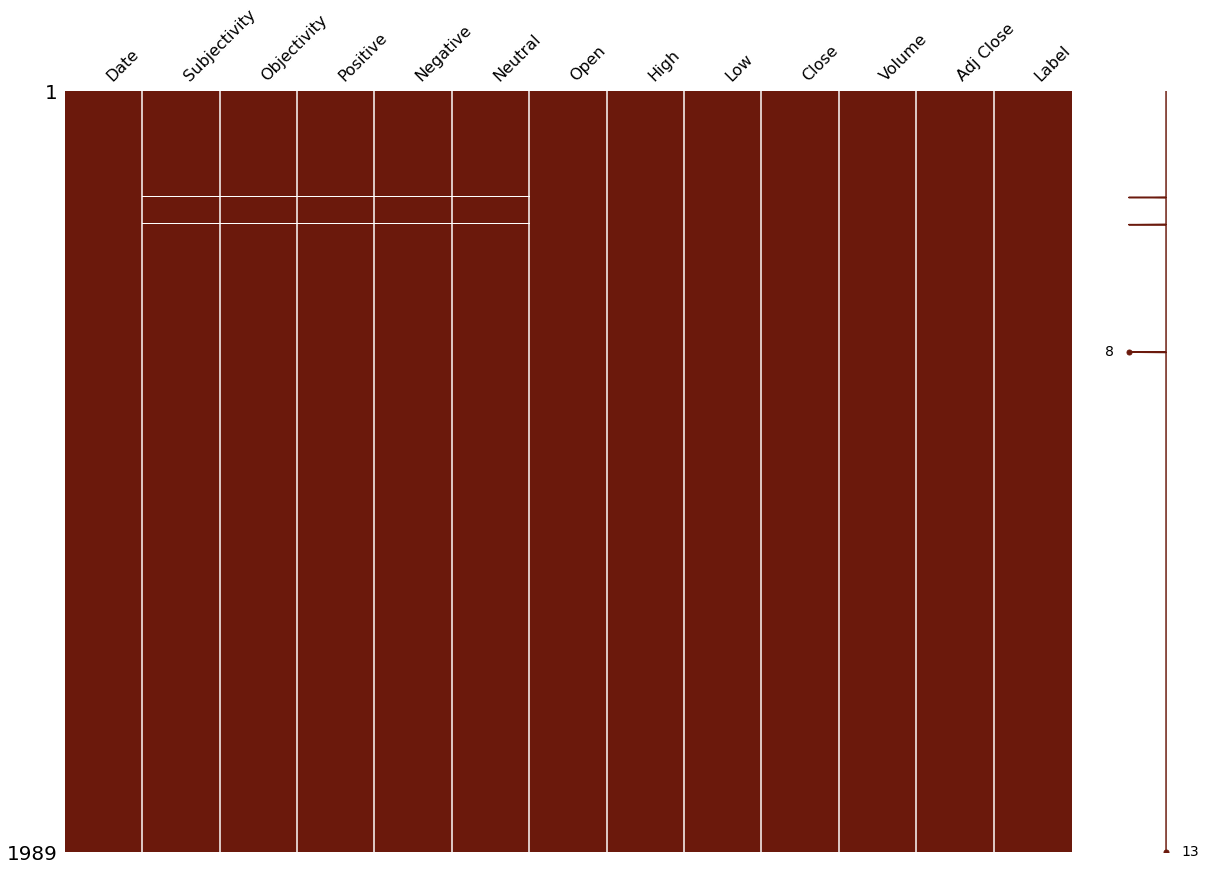

In [173]:
md_copy = merged_dataframe
md_copy = md_copy.replace(-1, np.NaN)
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=md_copy.iloc[:,0:13], figsize=(20, 14), color=(0.42, 0.1, 0.05))

In [174]:
# 查看各資料的資料型態和數量
print(merged_dataframe.count())
# 把NaN數據改為該特徵的平均分數
nan_list = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral']
for col in nan_list:
    merged_dataframe[col] = merged_dataframe[col].fillna(merged_dataframe[col].mean())
#fillna是用在填充NaN數據

Date            1989
Subjectivity    1986
Objectivity     1986
Positive        1986
Negative        1986
Neutral         1986
Open            1989
High            1989
Low             1989
Close           1989
Volume          1989
Adj Close       1989
Label           1989
dtype: int64


## Correlation Map for features:

### 我們來觀察資料的特徵column彼此間的相關性
### 在此我們有幾個發現：
### 1. Objectivity 與Neutral的相關性 = 1，兩者也確實都相同
### 2. Subjectivity與Objectivity,Neutral 相關性 = -1，即剛好是互補關係（相加等於1）
### 3. 開高低收特徵彼此相關性 = 1，應是由於當日的開高低收就是小數點到個位數上的差異，故大小相近。
### 4. 每一筆特徵單獨與Label(y data)的關聯性很低

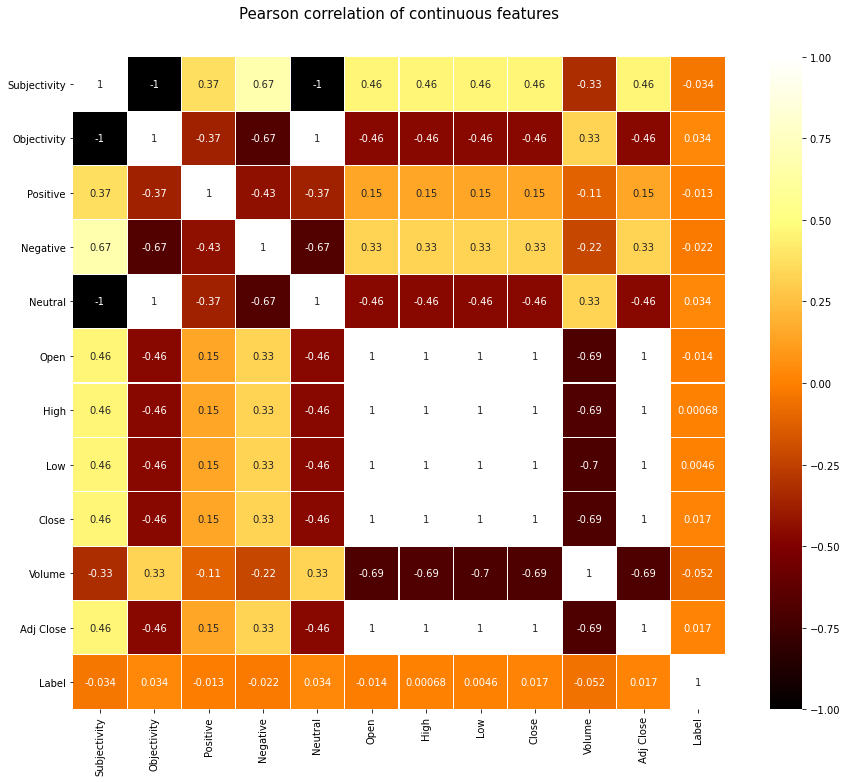

In [175]:
colormap = pyplot.cm.afmhot
pyplot.figure(figsize=(16,12))
pyplot.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(merged_dataframe.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
pyplot.show()

# 階段二：模型訓練與調整參數精準度

# 2.1 機器學習模型比較與參數微調
# 2.1.1 Compare trainging model.
## 接著我們挑選機器學習模型

Logistic Regression
Linear Discriminant Analysis
K Nearest Neighbors
Naive Bayes
Support Vector Classifier
Decision trees
Random Forest Classifier
XGBoost

## 在資料集上我們將會用兩種分法：
### 一組是模型比較 training set : 1393 , testing set : 596
### 一組是參數微調 training set : 1393, validation set : 298 , testing set : 298

## 分配train set, test set

In [176]:
X = merged_dataframe.loc[:,'Subjectivity':'Adj Close']
y = merged_dataframe.loc[:,'Label']


# Split the initial 70% of the data as training set and the remaining 30% data as the testing set
train_size = int(len(X.index) * 0.7)
X_train, X_test = X.loc[0:train_size, :], X.loc[train_size+1: len(X.index), :]
y_train, y_test = y.loc[0:train_size], y.loc[train_size+1: len(X.index)]

print('Observations: %d' % (len(X.index)))
print('X Training Observations: %d' % (len(X_train.index)))
print('X Testing Observations: %d' % (len(X_test.index)))
print('y Training Observations: %d' % (len(y_train)))
print('y Testing Observations: %d' % (len(y_test)))
"""
pyplot.plot(y_train)
pyplot.plot([None for i in y_train] + [x for x in y_test])
pyplot.xlabel('time')
pyplot.ylabel('y data')
pyplot.title('y data train,test Schematic diagram')
pyplot.show()
num_folds = 10
scoring = 'accuracy'
"""

Observations: 1989
X Training Observations: 1393
X Testing Observations: 596
y Training Observations: 1393
y Testing Observations: 596


"\npyplot.plot(y_train)\npyplot.plot([None for i in y_train] + [x for x in y_test])\npyplot.xlabel('time')\npyplot.ylabel('y data')\npyplot.title('y data train,test Schematic diagram')\npyplot.show()\nnum_folds = 10\nscoring = 'accuracy'\n"

## 分配train, validation, test set

In [177]:
# Separate the dataframe for input(X) and output variables(y)
X = merged_dataframe.loc[:,'Subjectivity':'Adj Close']
y = merged_dataframe.loc[:,'Label']

# Split the initial 70% of the data as training set , 15% of validation set and the remaining 15% data as the testing set
train_size = int(len(X.index) * 0.7)
validation_size = int(len(X.index) * 0.15)

X_train_finetune, X_validation_finetune, X_test_finetune = X.loc[0:train_size, :], X.loc[train_size+1: train_size+validation_size, :],X.loc[train_size+validation_size+1: len(X.index), :]
y_train_finetune, y_validation_finetune, y_test_finetune = y.loc[0:train_size], y.loc[train_size+1: train_size+validation_size], y.loc[train_size+validation_size+1: len(X.index)]

print('Observations: %d' % (len(X.index)))
print('X Training Observations: %d' % (len(X_train_finetune.index)))
print('X Validation Observations: %d' % (len(X_validation_finetune.index)))
print('X Testing Observations: %d' % (len(X_test_finetune.index)))
print('y Training Observations: %d' % (len(y_train_finetune)))
print('y Validation Observations: %d' % (len(y_validation_finetune)))
print('y Testing Observations: %d' % (len(y_test_finetune)))
"""
pyplot.plot(y_train_finetune)
pyplot.plot([None for i in y_train_finetune] + [x for x in y_validation_finetune])
pyplot.plot([None for i in y_train_finetune] + [None for i in y_validation_finetune] + [x for x in y_test_finetune])
pyplot.xlabel('time')
pyplot.ylabel('y data')
pyplot.title('y data train,validation,test Schematic diagram')
pyplot.show()
num_folds = 10
scoring = 'accuracy'
"""

Observations: 1989
X Training Observations: 1393
X Validation Observations: 298
X Testing Observations: 298
y Training Observations: 1393
y Validation Observations: 298
y Testing Observations: 298


"\npyplot.plot(y_train_finetune)\npyplot.plot([None for i in y_train_finetune] + [x for x in y_validation_finetune])\npyplot.plot([None for i in y_train_finetune] + [None for i in y_validation_finetune] + [x for x in y_test_finetune])\npyplot.xlabel('time')\npyplot.ylabel('y data')\npyplot.title('y data train,validation,test Schematic diagram')\npyplot.show()\nnum_folds = 10\nscoring = 'accuracy'\n"

## 放入機器學習 model，訓練並比較各模型在test set 上的accuracy

In [178]:
# Append the models to the models list
models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier()))

In [179]:
# Evaluate each algorithm for accuracy
results = []
names = []


for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    print(name + ": " + str(accu_score))
    

LR: 0.5302013422818792
LDA: 0.9496644295302014
KNN: 0.4597315436241611
CART: 0.5486577181208053
NB: 0.5318791946308725
SVM: 0.5318791946308725
RF: 0.5671140939597316
XGBoost: 0.6040268456375839


## 經過測試我們看到LDA與XGBoost表現良好
## 故我們分別觀察兩者的confusion matrix, classification report

## LDA表現：
## 十分讚

accuracy score:
0.9496644295302014
｜true  p    false n｜
｜false p    true  n｜
confusion matrix: 
[[256  24]
 [  6 310]]
classification report: 
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       280
           1       0.93      0.98      0.95       316

    accuracy                           0.95       596
   macro avg       0.95      0.95      0.95       596
weighted avg       0.95      0.95      0.95       596

(596,)
roc auc is :0.99500452079566
AUC using cross val: [0.99441964 0.99074074 0.98204265 0.98755656 0.99666667 1.
 1.         0.98951049 0.98928571 0.97569444]
Mean AUC score is: 0.9905916908300487


/home/kevinshieh0225/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



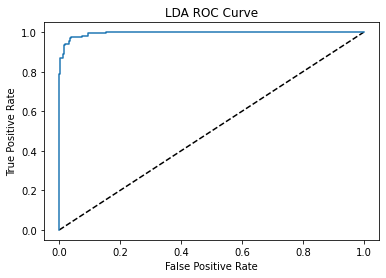

In [152]:
# prepare the model LDA
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledTestX = scaler.transform(X_test)
predictions = model_lda.predict(rescaledTestX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("｜true  p    false n｜")
print("｜false p    true  n｜")
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))

# Generating the ROC curve
y_pred_proba = model_lda.predict_proba(rescaledTestX)[:,1]
print(y_pred_proba.shape)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('LDA ROC Curve')
pyplot.show()

# AUC score using cross validation
kfold_val = KFold(n_splits=num_folds, random_state=42)
auc_score = cross_val_score(model_lda, rescaledTestX, y_test, cv=kfold_val, scoring='roc_auc')


    
print("AUC using cross val: " + str(auc_score))
mean_auc = np.mean(auc_score)
print("Mean AUC score is: " + str(mean_auc))

## XGB表現：
## 沒那麼讚

accuracy score:
0.6040268456375839
｜true  p    false n｜
｜false p    true  n｜
confusion matrix: 
[[ 84 196]
 [ 40 276]]
classification report: 
              precision    recall  f1-score   support

           0       0.68      0.30      0.42       280
           1       0.58      0.87      0.70       316

    accuracy                           0.60       596
   macro avg       0.63      0.59      0.56       596
weighted avg       0.63      0.60      0.57       596

roc auc is :0.6409697106690777


/home/kevinshieh0225/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



AUC using cross val: [0.88058036 0.77025463 0.93995511 0.91176471 0.97666667 0.96273637
 0.97126437 0.95454545 0.96785714 0.9525463 ]
Mean AUC score is: 0.9288171101206875


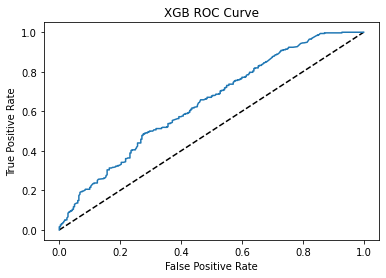

In [154]:
model_xgb = XGBClassifier()
model_xgb.fit(rescaledX, y_train)
# estimate accuracy on test dataset
rescaledTestX = scaler.transform(X_test)
predictions = model_xgb.predict(rescaledTestX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("｜true  p    false n｜")
print("｜false p    true  n｜")
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))

y_pred_proba = model_xgb.predict_proba(rescaledTestX)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('XGB ROC Curve')
pyplot.show()

# AUC score using cross validation
kfold_val = KFold(n_splits=num_folds, random_state=42)
auc_score = cross_val_score(model_xgb, rescaledTestX, y_test, cv=kfold_val, scoring='roc_auc')
print("AUC using cross val: " + str(auc_score))
mean_auc = np.mean(auc_score)
print("Mean AUC score is: " + str(mean_auc))

# 2.1.2 Fine Tuning XGBoost

#### As of now the model that seems to be performing the second is the XGBoost model.

#### Lets see if we can fine tune it further to increase the accuracy of the model.

#### The main parameters which can be used for fine tuning the XGBoost model are the n_estimators and the max_depth parameters.

#### n_estimators: XGBoost is an additive model, multiple models are created on different samples of data and the model learns after training of different samples. How many samples are the optimum best for the XGBoost to train from is usually unknown and the best way to find out is to check by training on different set of estimators.

#### Lets take a list of n_estimators = [150, 200, 250, 450, 500, 550, 1000]

#### max_depth: XGBoost learns in the form of a tree model and the number of depths for that tree needs to be set. This parameter is also not known. So lets try on multiple set of depths.
#### max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

#### Below , we are training the XGBoost classifier on different combinations of max depth and estimators. This output will print out the  best parameters as well as the highest accuracy achieved using those parameters.

#### Below we can see that the accuracy has improved by around ~5%, i. e from 58% to 62% at 550 estimators and max depth of 3.

In [34]:
# XGBoost on Stock Price dataset, Tune n_estimators and max_depth
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib

matplotlib.use('Agg')
model = XGBClassifier()
n_estimators = [150, 200, 250, 450, 500, 550, 1000]
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
print(max_depth)
best_depth = 0
best_estimator = 0
max_score = 0
for n in n_estimators:
    for md in max_depth:
        model = XGBClassifier(n_estimators=n, max_depth=md)
        model.fit(X_train_finetune, y_train_finetune)
        y_pred = model.predict(X_validation_finetune)
        score = accuracy_score(y_validation_finetune, y_pred)
        if score > max_score:
            max_score = score
            best_depth = md
            best_estimator = n
        print("Score is " + str(score) + " at depth of " + str(md) + " and estimator " + str(n))
print("Best score is " + str(max_score) + " at depth of " + str(best_depth) + " and estimator of " + str(best_estimator))

model = XGBClassifier(n_estimators=best_estimator, max_depth=best_depth)
model.fit(X_train_finetune, y_train_finetune)
y_pred = model.predict(X_test_finetune)
score = accuracy_score(y_test_finetune, y_pred)
    
print("the best estimator score in test data is"+str(score))


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Score is 0.5738255033557047 at depth of 1 and estimator 150
Score is 0.6073825503355704 at depth of 2 and estimator 150
Score is 0.6040268456375839 at depth of 3 and estimator 150
Score is 0.6208053691275168 at depth of 4 and estimator 150
Score is 0.6208053691275168 at depth of 5 and estimator 150
Score is 0.6241610738255033 at depth of 6 and estimator 150
Score is 0.5838926174496645 at depth of 7 and estimator 150
Score is 0.6073825503355704 at depth of 8 and estimator 150
Score is 0.5805369127516778 at depth of 9 and estimator 150
Score is 0.6040268456375839 at depth of 10 and estimator 150
Score is 0.5503355704697986 at depth of 11 and estimator 150
Score is 0.5973154362416108 at depth of 12 and estimator 150
Score is 0.5738255033557047 at depth of 1 and estimator 200
Score is 0.6073825503355704 at depth of 2 and estimator 200
Score is 0.6140939597315436 at depth of 3 and estimator 200
Score is 0.6241610738255033 at depth of 4 and estimator 2

# 2.1.3 Feature Importances:

## 我們找出XGB的"重要特徵"，只使用重要特徵來做預測，看看結果如何：

In [156]:
#刪除"Label"這行column(axis=1)
features = merged_dataframe.drop(['Label'],axis=1).columns.values
#print(features.shape())
print(features)
#feature_importances_是排列xgb的特徵重要度評分
x, y = (list(x) for x in zip(*sorted(zip(model_xgb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Feature importance for XGBoost',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances for XGBoost',
     width = 1000, height = 1000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')


## Fine tuning with important features:

#### As explained earlier in the feature importance plot section, lets use the most important features and see if it improves the accuracy of the model.

#### After training using the most important features, we do not see much improvement in our model. Hence, lets not use that in further tuning. The model accuracy still remains at 62%

In [158]:
imp_features_df = merged_dataframe[['Low', "Neutral", 'Close', 'Objectivity', 'High','Positive']]
X = imp_features_df.loc[:,'Low':'Positive']
print(X.head())

Xi_train, Xi_test = X.loc[0:train_size, :], X.loc[train_size+1: len(X.index), :]

clf = XGBClassifier(n_estimators=200, max_depth=6)
clf.fit(Xi_train, y_train)
yi_pred = clf.predict(Xi_test)
print("")
print("accuracy score:")
print(accuracy_score(y_test, yi_pred))
print("｜true  p    false n｜")
print("｜false p    true  n｜")
print("confusion matrix: ")
print(confusion_matrix(y_test, yi_pred))
print("classification report: ")
print(classification_report(y_test, yi_pred))

            Low    Neutral         Close  Objectivity          High   Positive
0  11388.040039  14.285714  11734.320312    14.285714  11759.959961  21.428571
1  11675.530273  22.222222  11782.349609    22.222222  11867.110352  33.333333
2  11601.519531  50.000000  11642.469727    50.000000  11782.349609  14.285714
3  11453.339844  60.000000  11532.959961    60.000000  11633.780273  20.000000
4  11450.889648  54.545455  11615.929688    54.545455  11718.280273  36.363636

accuracy score:
0.5654362416107382
｜true  p    false n｜
｜false p    true  n｜
confusion matrix: 
[[ 98 182]
 [ 77 239]]
classification report: 
              precision    recall  f1-score   support

           0       0.56      0.35      0.43       280
           1       0.57      0.76      0.65       316

    accuracy                           0.57       596
   macro avg       0.56      0.55      0.54       596
weighted avg       0.56      0.57      0.55       596



## 抽出高重要性特徵，測試分數變低
### all feature  XGBmodel test score：0.603
### top 6 important feature XGBmodel test score：0.576




# 2.2 PCA transformation:  
# 2.2.1 PCA+XGB
## PCA主成分分析，是另一種透過降維方式來協助機器學習的手段，不同的是LDA是監督式學習

### In the below model, lets reduce the dimension of the data down to 3 and then train it using XGBoost to see if the performance is improved. PCA reduces the dimensions of the data, however it preserves the data from all columns, it only does the job of bringing down all the dimensions to 2-3 dimensions. The main dimension will be the dimension with highest amount of variance, i.e the spread of data.

In [180]:
from sklearn.decomposition import PCA

X = merged_dataframe.loc[:,'Subjectivity':'Adj Close']
y = merged_dataframe.loc[:,'Label']

pca = PCA(n_components=3)#主成分的維數
pca.fit(X)
transformed = pca.transform(X)

transformed.shape
print(type(transformed))

<class 'numpy.ndarray'>


## 在PCA處理data後

## 我們的xgboost在test data得到94%accuracy

In [182]:
pca_df = pd.DataFrame(transformed)

X_train_pca, X_test_pca = pca_df.loc[0:train_size, :], pca_df.loc[train_size+1: len(X.index), :]

X_train_pca_finetune, X_validation_pca_finetune, X_test_pca_finetune = pca_df.loc[0:train_size, :], pca_df.loc[train_size+1: train_size+validation_size, :],pca_df.loc[train_size+validation_size+1: len(X.index), :]

clf = XGBClassifier(n_estimators=200, max_depth=6)
clf.fit(X_train_pca, y_train)
y_pred_pca = clf.predict(X_test_pca)
score = accuracy_score(y_test, y_pred_pca)
print("Score is "+ str(score))


Score is 0.9412751677852349


#### However, as explained earlier, we cannot totally rely on the accuracy score to be the most acurate test of the model . Lets take a look at the confusion matrix as well as the classification report.

#### The confusion matrix looks good as we have a good number of true positives and true negatives.
#### The top left corner is the true positive and the bottom right corner of the matrix is the true negatives.
#### True Positive: No. of predictions which are positive and are actually positive.
#### True Negative: No. of predictions which are negative and are actually negative.
#### The bottom left and top right are false positive and false negative. We can see that the number of false positive's and false negative's are quite low. Thus we can say that the predictions performed by the model is very good.

｜true  p    false n｜
｜false p    true  n｜
#### The precision, recal and f1 score is also very good.
## Precision is 0.94
## Recall is 0.94
## f1-score is 0.94

｜true  p    false n｜
｜false p    true  n｜
Confusion Matrix: 
[[254  26]
 [  9 307]]
Classification report: 
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       280
           1       0.92      0.97      0.95       316

    accuracy                           0.94       596
   macro avg       0.94      0.94      0.94       596
weighted avg       0.94      0.94      0.94       596

AUC score is 0.9858103526220615
roc auc is :0.9858103526220615


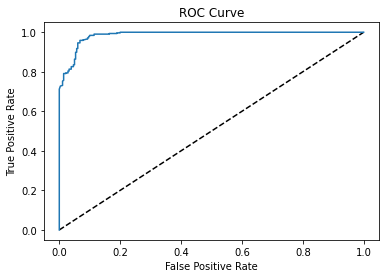

In [183]:
pca_matrix = confusion_matrix(y_test, y_pred_pca)
pca_report = classification_report(y_test, y_pred_pca)
print("｜true  p    false n｜")
print("｜false p    true  n｜")
print("Confusion Matrix: \n" + str(pca_matrix))
print("Classification report: \n" + str(pca_report))

# Generating the ROC curve
y_pred_proba_pca = clf.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_pca)
roc_auc = auc(fpr, tpr)
print("AUC score is " + str(roc_auc))

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()


# 在pca主成分分析後續實驗：
## 2.2.2 研究各模型在pca數據調整後的表現情形
## 2.2.3不同主成分下XGboost的表現狀況

# 2.2.2 研究各模型在pca數據調整後的表現情形

In [184]:
# Evaluate each algorithm for accuracy
models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier(n_estimators=200, max_depth=6)))
results = []
names = []

for name, model in models:
    clf = model
    clf.fit(X_train_pca, y_train)
    y_pred_pca = clf.predict(X_test_pca)
    accu_score = accuracy_score(y_test, y_pred_pca)
    print(name + ": " + str(accu_score))

LR: 0.5419463087248322
LDA: 0.9261744966442953
KNN: 0.4597315436241611
CART: 0.8909395973154363
NB: 0.535234899328859
SVM: 0.5335570469798657
RF: 0.9412751677852349
XGBoost: 0.9412751677852349


### 我們比較一下未使用PCA處理的結果：
          原先的accuracy      使用PCA後的accuracy
    LR:   0.5309882747068677  0.5419463087248322
    LDA:  0.949748743718593   0.9261744966442953
    KNN:  0.45896147403685095 0.4597315436241611
    CART: 0.5561139028475712  0.889261744966443
    NB:   0.5326633165829145  0.535234899328859
    SVM:  0.5326633165829145  0.5335570469798657
    RF:   0.576214405360134   0.9429530201342282
    XGB:  0.6046901172529313  0.9463087248322147
   
         原先的accuracy      使用PCA後的accuracy
    LR   0.531               0.542 
    LDA  0.950               0.926 Down
    KNN  0.459               0.460 
    CART 0.556               0.889 Up
    NB   0.533               0.535 
    SVM  0.533               0.534 
    RF   0.576               0.943 Up
    XGB  0.605               0.946 Up

### CART、RF、XGB有顯著上升；原先表現最好的LDA下降

# 2.2.3不同主成分下XGboost的表現狀況

In [107]:
X = merged_dataframe.loc[:,'Subjectivity':'Adj Close']
y = merged_dataframe.loc[:,'Label']

model = XGBClassifier()

n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

best_components = 0
max_score = 0

for n in n_components:
    #PCA處理
    pca = PCA(n_components=n)#主成分的維數
    pca.fit(X)
    transformed = pca.transform(X)
    pca_df = pd.DataFrame(transformed)
    X_train_pca_finetune, X_validation_pca_finetune, X_test_pca_finetune = pca_df.loc[0:train_size, :], pca_df.loc[train_size+1: train_size+validation_size, :],pca_df.loc[train_size+validation_size+1: len(X.index), :]
    #
    #帶入RF model
    model.fit(X_train_pca_finetune, y_train_finetune)
    y_pred = model.predict(X_validation_pca_finetune)
    score = accuracy_score(y_validation_finetune, y_pred)
    if score > max_score:
        max_score = score
        best_components = n
    print("Score is " + str(score) + " at components of " + str(n))
print("Best score is " + str(max_score) + " at components of " + str(best_components))

pca = PCA(n_components=best_components)#主成分的維數
pca.fit(X)
transformed = pca.transform(X)
pca_df = pd.DataFrame(transformed)
X_train_pca_finetune, X_validation_pca_finetune, X_test_pca_finetune = pca_df.loc[0:train_size, :], pca_df.loc[train_size+1: train_size+validation_size, :],pca_df.loc[train_size+validation_size+1: len(X.index), :]
model.fit(X_train_pca_finetune, y_train_finetune)
y_pred = model.predict(X_test_pca_finetune)
score = accuracy_score(y_test_finetune, y_pred)

print("Best pca components of score in test data is " + str(score))


Score is 0.4697986577181208 at components of 1
Score is 0.4966442953020134 at components of 2
Score is 0.9563758389261745 at components of 3
Score is 0.9463087248322147 at components of 4
Score is 0.9429530201342282 at components of 5
Score is 0.9664429530201343 at components of 6
Score is 0.9731543624161074 at components of 7
Score is 0.9697986577181208 at components of 8
Score is 0.9664429530201343 at components of 9
Score is 0.9664429530201343 at components of 10
Score is 0.9697986577181208 at components of 11
Best score is 0.9731543624161074 at components of 7
Best pca components of score in test data is 0.9630872483221476


### 以XGB model測試後在components 於n = 8時有最佳accuracy
### 接著我們看看在PCA n = 8 之下，finetune xgb的最佳結果為何？

In [108]:
# XGBoost on Stock Price dataset, Tune n_estimators and max_depth
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib

matplotlib.use('Agg')
model = XGBClassifier()
n_estimators = [150, 200, 250, 450, 500, 550, 1000]
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
print(max_depth)
best_depth = 0
best_estimator = 0
max_score = 0

for n in n_estimators:
    for md in max_depth:
        model = XGBClassifier(n_estimators=n, max_depth=md)
        model.fit(X_train_pca_finetune, y_train_finetune)
        y_pred = model.predict(X_validation_pca_finetune)
        score = accuracy_score(y_validation_finetune, y_pred)
        if score > max_score:
            max_score = score
            best_depth = md
            best_estimator = n
        print("Score is " + str(score) + " at depth of " + str(md) + " and estimator " + str(n))
print("Best score is " + str(max_score) + " at depth of " + str(best_depth) + " and estimator of " + str(best_estimator))

model = XGBClassifier(n_estimators=best_estimator, max_depth=best_depth)
model.fit(X_train_pca_finetune, y_train_finetune)
y_pred = model.predict(X_test_pca_finetune)
score = accuracy_score(y_test_finetune, y_pred)
    
print("the best estimator score in test data is"+str(score))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Score is 0.9731543624161074 at depth of 1 and estimator 150
Score is 0.9798657718120806 at depth of 2 and estimator 150
Score is 0.9765100671140939 at depth of 3 and estimator 150
Score is 0.9765100671140939 at depth of 4 and estimator 150
Score is 0.9731543624161074 at depth of 5 and estimator 150
Score is 0.9731543624161074 at depth of 6 and estimator 150
Score is 0.9697986577181208 at depth of 7 and estimator 150
Score is 0.9697986577181208 at depth of 8 and estimator 150
Score is 0.9731543624161074 at depth of 9 and estimator 150
Score is 0.9731543624161074 at depth of 10 and estimator 150
Score is 0.9731543624161074 at depth of 11 and estimator 150
Score is 0.9731543624161074 at depth of 12 and estimator 150
Score is 0.9697986577181208 at depth of 1 and estimator 200
Score is 0.9798657718120806 at depth of 2 and estimator 200
Score is 0.9765100671140939 at depth of 3 and estimator 200
Score is 0.9765100671140939 at depth of 4 and estimator 2

# 3.實用性測試
# 3.1 隔日股票預測
## 另外我好奇，如果預測的不是當天股票，而是隔天的呢？基於實用性原則，我們還是得對未來做預測才有意義，然而透過文獻，時間越久新聞對股票的影響性越小，這似乎對我們不利。所以我們來看看效果

In [188]:
X_train_pca_tommorrow, X_test_pca_tommorrow = pca_df.loc[0:train_size, :], pca_df.loc[train_size+1: len(pca_df.index)-2, :]
y_train_tommorrow,  y_test_tommorrow = y.loc[1:train_size+1], y.loc[train_size+2: len(pca_df.index)-1]
print(pca_df.shape)
print(len(pca_df.index))
print(str(train_size))
print(str(len(pca_df.index)))
print(str())
print(str())
print(X_train_pca_tommorrow.shape)
print(X_test_pca_tommorrow.shape)
print(y_train_tommorrow.shape)
print(y_test_tommorrow.shape)




model = XGBClassifier(n_estimators=200, max_depth=6)
model.fit(X_train_pca_tommorrow, y_train_tommorrow)
y_pred = model.predict(X_test_pca_tommorrow)
score = accuracy_score(y_test_tommorrow, y_pred)
print("XGB with pca(n=8): " + str(score))

(1989, 3)
1989
1392
1989


(1393, 3)
(595, 3)
(1393,)
(595,)
XGB with pca(n=8): 0.45546218487394957


In [189]:
X_train_tommorrow, X_test_tommorrow = X.loc[0:train_size, :], X.loc[train_size+1: len(X.index)-2, :]
y_train_tommorrow, y_test_tommorrow = y.loc[1:train_size+1], y.loc[train_size+2: len(X.index)-1]

# Evaluate each algorithm for accuracy
results = []
names = []

models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier(n_estimators=200, max_depth=6)))

for name, model in models:
    clf = model
    clf.fit(X_train_tommorrow, y_train_tommorrow)
    y_pred = clf.predict(X_test_tommorrow)
    accu_score = accuracy_score(y_test_tommorrow, y_pred)
    print(name + ": " + str(accu_score))


LR: 0.5310924369747899
LDA: 0.5126050420168067
KNN: 0.47394957983193275
CART: 0.4773109243697479
NB: 0.5294117647058824
SVM: 0.5327731092436975
RF: 0.4789915966386555
XGBoost: 0.5210084033613446


## 所有的預測皆嚴重下滑。這似乎呼應我們在文獻得知的，新聞影響力是短時間性的。然而我們不禁想，是否有其他因素導致我們只能對當日新聞做出有效的預測？

# 3.2 實用性預測：短線資料無close,volume
## 當我拿掉close,volume的數據時，模型的測驗效果如何？
## 拿掉close的特徵也符合實際情況：我們若要做當天收盤買賣，理應不知道收盤的數值的

In [191]:
imp_features_df = merged_dataframe[['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral', 'Open', 'High', 'Low', 'Volume']]
#imp_features_df = merged_dataframe[['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral', 'Open', 'High', 'Low', 'Volume']]
X_real = imp_features_df.loc[:,'Subjectivity':'Low']

X_train_real, X_test_real = X_real.loc[0:train_size, :], X_real.loc[train_size+1: len(X.index)-1, :]
y_train_real, y_test_real = y.loc[0:train_size], y.loc[train_size+1: len(X.index)-1]

results = []
names = []

models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier(n_estimators=200, max_depth=6)))

for name, model in models:
    clf = model
    clf.fit(X_train_real, y_train_real)
    y_pred = clf.predict(X_test_real)
    accu_score = accuracy_score(y_test_real, y_pred)
    print(name + ": " + str(accu_score))

LR: 0.8741610738255033
LDA: 0.8624161073825504
KNN: 0.5369127516778524
CART: 0.5939597315436241
NB: 0.4966442953020134
SVM: 0.5302013422818792
RF: 0.5100671140939598
XGBoost: 0.5738255033557047


## 比較各數值：
         抽取調close,volumn  原先的accuracy
    LR   0.874               0.553
    LDA  0.862               0.932
    KNN  0.537               0.473
    CART 0.594               0.587
    NB   0.497               0.550
    SVM  0.530               0.550
    RF   0.510               0.546
    XGB  0.574               0.617

### 測試pca+xgb

In [192]:
pca = PCA(n_components=best_components)#主成分的維數
pca.fit(X_real)
transformed = pca.transform(X_real)
pca_df = pd.DataFrame(transformed)
X_train_pca_real, X_test_pca_real = pca_df.loc[0:train_size, :], pca_df.loc[train_size+1: len(X.index)-1, :]
y_train_pca_real, y_test_pca_real = y.loc[0:train_size], y.loc[train_size+1: len(X.index)-1]

model = XGBClassifier(n_estimators=200, max_depth=6)
model.fit(X_train_pca_real, y_train_pca_real)
y_pred = model.predict(X_test_pca_real)
accu_score = accuracy_score(y_test_pca_real, y_pred)
print(name + ": " + str(accu_score))

XGBoost: 0.8523489932885906


## 由此可見logistic regression的分數明顯上升，而LDA在此的表現下降。

## 我們再使用PCA轉換後搭配XGBoost，在此得到了0.856的預測準度。


# 3.3 只預測開高低收
## 最後我們抽取掉新聞情感分析的五項特徵，只以K線資訊預測當日走勢，試圖了解新聞情感分析佔本次實驗的影響重要性程度：

In [88]:
imp_features_df = merged_dataframe[[ 'Open', 'High', 'Low','Volume','Close']]
X_real = imp_features_df.loc[:,'Open':'Close']
print(X_real.shape)

X_train_real, X_test_real = X_real.loc[0:train_size, :], X_real.loc[train_size+1: len(X.index)-1, :]
y_train_real, y_test_real = y.loc[0:train_size], y.loc[train_size+1: len(X.index)-1]

results = []
names = []

models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier(n_estimators=200, max_depth=6)))

for name, model in models:
    clf = model
    clf.fit(X_train_real, y_train_real)
    y_pred = clf.predict(X_test_real)
    accu_score = accuracy_score(y_test_real, y_pred)
    print(name + ": " + str(accu_score))

(1989, 5)
LR: 0.5302013422818792
LDA: 0.9546979865771812
KNN: 0.4597315436241611
CART: 0.5922818791946308
NB: 0.5302013422818792
SVM: 0.5335570469798657
RF: 0.5838926174496645
XGBoost: 0.5671140939597316


## 我們發現LDA仍然維持極高的水準，而比較原本的預測結果發現，其實差別不大，由此得知我們本次實驗雖欲證明新聞文本sentiment analysis能在股票預測有好的表現，但結果不盡人意，sentiment analysis的特徵的影響性微乎其微。